In [20]:
import warnings
from matplotlib.ticker import MultipleLocator
import string
from prettytable import PrettyTable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import re
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import ast

In [21]:
df = pd.read_csv("../input/multilabelsongs/MultiLabelSongs_EN_prepared.csv")
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,I will never bother you I will never promise t...,"['Calmness', 'Sadness']"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Here we go My big ego is gon na get me in trou...,"['Power', 'Tension']"


In [22]:
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,I will never bother you I will never promise t...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Here we go My big ego is gon na get me in trou...,"Power, Tension"


In [23]:
df['labels'] = df['labels'].str.split(',\s*')
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,I will never bother you I will never promise t...,"[Calmness, Sadness]"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Here we go My big ego is gon na get me in trou...,"[Power, Tension]"


In [24]:
all_emotions = sorted(list(set([e for labels in df['labels'] for e in labels])))
mlb = MultiLabelBinarizer(classes=all_emotions)
labels_bin = mlb.fit_transform(df['labels'])

for i, label in enumerate(mlb.classes_):
    print(f"{i}: {label}")

0: Amazement
1: Calmness
2: Joyful activation
3: Nostalgia
4: Power
5: Sadness
6: Solemnity
7: Tenderness
8: Tension


In [25]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['lyrics'].tolist(), labels_bin, test_size=0.2, random_state=42
)

In [26]:
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=all_emotions, zero_division=0)
    return f1_micro, f1_macro, precision, recall, acc, report, all_labels, all_preds

In [27]:
def plot_confusion_per_class(true_labels, pred_labels, class_names, epoch=None):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(true_labels[:, i], pred_labels[:, i])
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not ' + class_name, class_name],
                    yticklabels=['Not ' + class_name, class_name])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        title = f"Confusion Matrix: {class_name}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        plt.title(title)
        plt.tight_layout()
        plt.show()

In [28]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(labels)
        }

class MultiLabelClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
        return logits 

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "xlm-roberta-base"
#model_name = "readerbench/RoBERT-base"
#model_name = "racai/distilbert-base-romanian-cased"
#model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MultiLabelClassificationModel(model_name, num_labels=len(all_emotions))
model.to(device)

train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)

idx = 0
sample = train_dataset[idx]
original_text = train_texts[idx]
print("=== Text original ===")
print(original_text)
print("\n=== Token IDs ===")
print(sample['input_ids'])
print("\n=== Attention Mask ===")
print(sample['attention_mask'])
print("\n=== Tokens ===")
print(tokenizer.convert_ids_to_tokens(sample['input_ids']))
print("\n=== Label ===")
print(sample['labels'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

=== Text original ===
Picture all the possibilities Picture all the possibilities Sounds like a love song Sounds like a love song The most incredible baby I can not see ' em coming down my eyes So I got ta make the song cry I can not see ' em coming down my eyes So I got ta make the song cry Good dude I know you love me like cooked food Even though a nigga got ta move like a crook move We was together on the block since free lunch We shoulda been together having Four Seasons brunch We used to use umbrellas to face the bad weather So now we travel first class to change the forecast Never in bunches just me and you I loved your point of view ‘ cause you held no punches Still I left you for months on end it is been months since I checked back in we are somewhere in a small town Somewhere locking a mall down Woodgrain four and change Armor All'd down I can understand why you want a divorce now Though I can not let you know it pride will not let me show it Pretend to be heroic that is just 

In [30]:
for param in model.model.embeddings.parameters():
    param.requires_grad = True

# Freeze primele 2 layere in encoder
#for name, param in model.model.encoder.named_parameters():
#    if "layer." in name:
#        layer_num = int(name.split('.')[1])
#        if layer_num < 2:
#            param.requires_grad = False

# Calculez pos_weight pe baza distribuției claselor în train_labels
if not isinstance(train_labels, torch.Tensor):
    train_labels_tensor = torch.tensor(train_labels)
else:
    train_labels_tensor = train_labels

pos_counts = train_labels_tensor.sum(dim=0)
neg_counts = train_labels_tensor.shape[0] - pos_counts
pos_weight = neg_counts / pos_counts
print("Pos weight per class:", pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-2)

Pos weight per class: tensor([4.1034, 3.8000, 2.4154, 1.6350, 1.5517, 0.9603, 2.1601, 1.3617, 1.0993])


In [31]:
train_losses = []
train_f1micros, train_f1macros, val_f1micros, val_f1macros = [], [], [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_accs, val_accs = [], []

best_model_path = "checkpoint.pt"
best_score = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if epoch == 0 and loop.n == 0:
            print("input_ids shape:", input_ids.shape)
            print("attention_mask shape:", attention_mask.shape)
            print("labels shape:", labels.shape)
            print("labels example:", labels[0])

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, _, _, _ = evaluate(model, train_loader)
    train_f1micros.append(train_f1_micro)
    train_f1macros.append(train_f1_macro)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_accs.append(train_acc)

    val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, _, _, _ = evaluate(model, val_loader)
    val_f1micros.append(val_f1_micro)
    val_f1macros.append(val_f1_macro)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_accs.append(val_acc)

    val_score = val_f1_micro + val_f1_macro
    if val_score > best_score:
        best_score = val_score
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(checkpoint, best_model_path)
        print("Checkpoint salvat cu succes.")
        print(f"Model salvat: Epoca {epoch+1} cu scor val total: {val_score:.4f}")

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}, Loss: {avg_train_loss:.4f}")
    print(f" Val  -> F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
labels shape: torch.Size([16, 9])
labels example: tensor([0., 1., 1., 0., 1., 0., 0., 0., 1.], device='cuda:0')


Epoch 1: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.999]


Checkpoint salvat cu succes.
Model salvat: Epoca 1 cu scor val total: 0.7249

Epoch 1
Train -> F1 macro: 0.3156, F1 micro: 0.4157, Precision: 0.4273, Recall: 0.4886, Acc: 0.0045, Loss: 0.9208
 Val  -> F1 macro: 0.3177, F1 micro: 0.4073, Precision: 0.4823, Recall: 0.4809, Acc: 0.0000


Epoch 2: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.816]


Checkpoint salvat cu succes.
Model salvat: Epoca 2 cu scor val total: 0.9932

Epoch 2
Train -> F1 macro: 0.4849, F1 micro: 0.5254, Precision: 0.4961, Recall: 0.6623, Acc: 0.0011, Loss: 0.8936
 Val  -> F1 macro: 0.4769, F1 micro: 0.5163, Precision: 0.4996, Recall: 0.6429, Acc: 0.0045


Epoch 3: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.708]


Checkpoint salvat cu succes.
Model salvat: Epoca 3 cu scor val total: 1.1008

Epoch 3
Train -> F1 macro: 0.5646, F1 micro: 0.5754, Precision: 0.5233, Recall: 0.6878, Acc: 0.0225, Loss: 0.8603
 Val  -> F1 macro: 0.5457, F1 micro: 0.5552, Precision: 0.5124, Recall: 0.6451, Acc: 0.0315


Epoch 4: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.731]


Checkpoint salvat cu succes.
Model salvat: Epoca 4 cu scor val total: 1.1937

Epoch 4
Train -> F1 macro: 0.6221, F1 micro: 0.6379, Precision: 0.5648, Recall: 0.7319, Acc: 0.0484, Loss: 0.8160
 Val  -> F1 macro: 0.5896, F1 micro: 0.6041, Precision: 0.5557, Recall: 0.6663, Acc: 0.0315


Epoch 5: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.764]



Epoch 5
Train -> F1 macro: 0.6258, F1 micro: 0.6369, Precision: 0.5870, Recall: 0.7448, Acc: 0.0484, Loss: 0.7698
 Val  -> F1 macro: 0.5711, F1 micro: 0.5857, Precision: 0.5655, Recall: 0.6464, Acc: 0.0270


Epoch 6: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.647]


Checkpoint salvat cu succes.
Model salvat: Epoca 6 cu scor val total: 1.1991

Epoch 6
Train -> F1 macro: 0.6809, F1 micro: 0.6945, Precision: 0.6038, Recall: 0.8041, Acc: 0.0867, Loss: 0.7341
 Val  -> F1 macro: 0.5864, F1 micro: 0.6126, Precision: 0.5366, Recall: 0.6598, Acc: 0.0495


Epoch 7: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.789]



Epoch 7
Train -> F1 macro: 0.6704, F1 micro: 0.6757, Precision: 0.6300, Recall: 0.7717, Acc: 0.0732, Loss: 0.7110
 Val  -> F1 macro: 0.5858, F1 micro: 0.5959, Precision: 0.5602, Recall: 0.6472, Acc: 0.0405


Epoch 8: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.552]


Checkpoint salvat cu succes.
Model salvat: Epoca 8 cu scor val total: 1.2304

Epoch 8
Train -> F1 macro: 0.7177, F1 micro: 0.7316, Precision: 0.6732, Recall: 0.7829, Acc: 0.1453, Loss: 0.6668
 Val  -> F1 macro: 0.6012, F1 micro: 0.6292, Precision: 0.5890, Recall: 0.6198, Acc: 0.0901


Epoch 9: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.561]



Epoch 9
Train -> F1 macro: 0.7435, F1 micro: 0.7517, Precision: 0.6828, Recall: 0.8319, Acc: 0.1385, Loss: 0.6254
 Val  -> F1 macro: 0.5895, F1 micro: 0.6233, Precision: 0.5760, Recall: 0.6261, Acc: 0.0721


Epoch 10: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.542]


Checkpoint salvat cu succes.
Model salvat: Epoca 10 cu scor val total: 1.2488

Epoch 10
Train -> F1 macro: 0.7672, F1 micro: 0.7745, Precision: 0.7010, Recall: 0.8582, Acc: 0.1836, Loss: 0.5875
 Val  -> F1 macro: 0.6100, F1 micro: 0.6389, Precision: 0.5856, Recall: 0.6529, Acc: 0.0586


Epoch 11: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.64] 



Epoch 11
Train -> F1 macro: 0.7791, F1 micro: 0.7837, Precision: 0.7288, Recall: 0.8524, Acc: 0.1982, Loss: 0.5512
 Val  -> F1 macro: 0.5843, F1 micro: 0.6183, Precision: 0.5868, Recall: 0.6075, Acc: 0.0676


Epoch 12: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.686]



Epoch 12
Train -> F1 macro: 0.7825, F1 micro: 0.7864, Precision: 0.7270, Recall: 0.8621, Acc: 0.1903, Loss: 0.5234
 Val  -> F1 macro: 0.5738, F1 micro: 0.6166, Precision: 0.5858, Recall: 0.6022, Acc: 0.0541


Epoch 13: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.572]



Epoch 13
Train -> F1 macro: 0.8135, F1 micro: 0.8177, Precision: 0.7593, Recall: 0.8822, Acc: 0.2545, Loss: 0.4952
 Val  -> F1 macro: 0.5799, F1 micro: 0.6190, Precision: 0.5831, Recall: 0.5944, Acc: 0.0856


Epoch 14: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.334]



Epoch 14
Train -> F1 macro: 0.8275, F1 micro: 0.8310, Precision: 0.7752, Recall: 0.8947, Acc: 0.3108, Loss: 0.4767
 Val  -> F1 macro: 0.5792, F1 micro: 0.6120, Precision: 0.5704, Recall: 0.5918, Acc: 0.0811


Epoch 15: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.428]



Epoch 15
Train -> F1 macro: 0.8340, F1 micro: 0.8403, Precision: 0.7749, Recall: 0.9168, Acc: 0.3187, Loss: 0.4498
 Val  -> F1 macro: 0.5827, F1 micro: 0.6074, Precision: 0.5527, Recall: 0.6248, Acc: 0.0495


Epoch 16: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.355]



Epoch 16
Train -> F1 macro: 0.8464, F1 micro: 0.8465, Precision: 0.7920, Recall: 0.9207, Acc: 0.3164, Loss: 0.4214
 Val  -> F1 macro: 0.5808, F1 micro: 0.6123, Precision: 0.5713, Recall: 0.6041, Acc: 0.0541


Epoch 17: 100%|██████████| 56/56 [00:59<00:00,  1.05s/it, loss=0.377]



Epoch 17
Train -> F1 macro: 0.8696, F1 micro: 0.8662, Precision: 0.8191, Recall: 0.9338, Acc: 0.3806, Loss: 0.3981
 Val  -> F1 macro: 0.5797, F1 micro: 0.6173, Precision: 0.5785, Recall: 0.5981, Acc: 0.0811


Epoch 18: 100%|██████████| 56/56 [00:59<00:00,  1.05s/it, loss=0.408]



Epoch 18
Train -> F1 macro: 0.8784, F1 micro: 0.8751, Precision: 0.8353, Recall: 0.9322, Acc: 0.4099, Loss: 0.3697
 Val  -> F1 macro: 0.5584, F1 micro: 0.5999, Precision: 0.5559, Recall: 0.5734, Acc: 0.0450


Epoch 19: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.484]



Epoch 19
Train -> F1 macro: 0.9006, F1 micro: 0.8994, Precision: 0.8605, Recall: 0.9473, Acc: 0.5214, Loss: 0.3383
 Val  -> F1 macro: 0.5659, F1 micro: 0.6067, Precision: 0.5659, Recall: 0.5695, Acc: 0.0721


Epoch 20: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.306]



Epoch 20
Train -> F1 macro: 0.9039, F1 micro: 0.8982, Precision: 0.8792, Recall: 0.9359, Acc: 0.5011, Loss: 0.3200
 Val  -> F1 macro: 0.5654, F1 micro: 0.6033, Precision: 0.5777, Recall: 0.5805, Acc: 0.0586


In [32]:
def load_model_from_checkpoint(path, model_name, num_labels, device):
    model = MultiLabelClassificationModel(model_name, num_labels)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model, checkpoint['epoch'], checkpoint['best_score']


GENERAL PERFORMANCE AFTER TRAINING
Train:
F1 macro: 0.7672, F1 micro: 0.7745, Precision: 0.7010, Recall: 0.8582, Acc: 0.1836
                   precision    recall  f1-score   support

        Amazement       0.61      0.94      0.74       174
         Calmness       0.55      0.90      0.68       185
Joyful activation       0.78      0.88      0.83       260
        Nostalgia       0.60      0.81      0.69       337
            Power       0.79      0.81      0.80       348
          Sadness       0.80      0.86      0.83       453
        Solemnity       0.58      0.75      0.65       281
       Tenderness       0.86      0.94      0.90       376
          Tension       0.73      0.84      0.78       423

        micro avg       0.71      0.85      0.77      2837
        macro avg       0.70      0.86      0.77      2837
     weighted avg       0.72      0.85      0.78      2837
      samples avg       0.72      0.87      0.77      2837


Validation:
F1 macro: 0.6100, F1 micro: 0.63

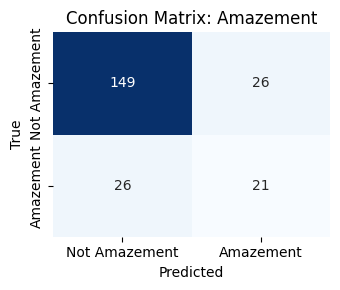

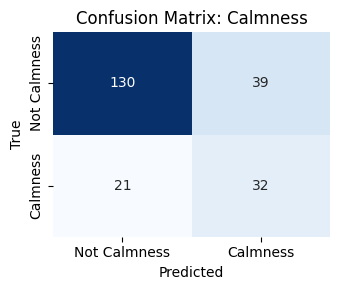

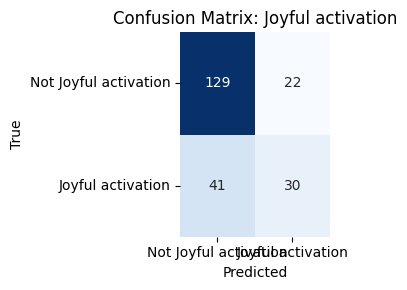

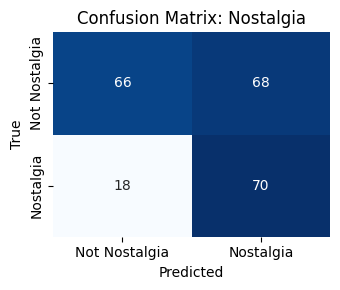

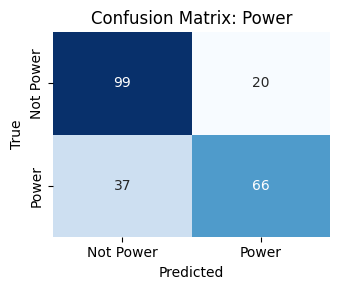

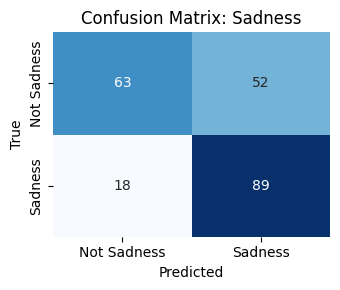

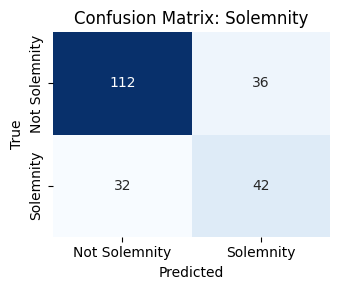

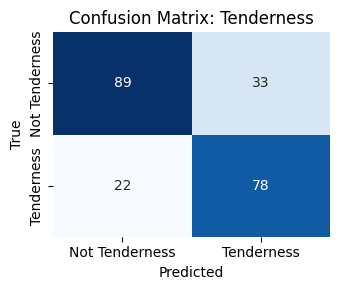

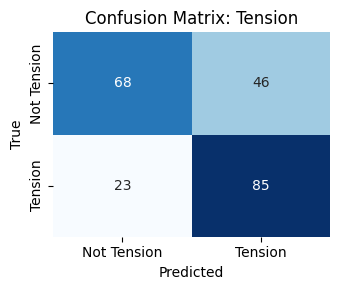

In [33]:
model_path = best_model_path

model, last_epoch, best_score = load_model_from_checkpoint(
    path=model_path,
    model_name=model_name,
    num_labels=len(all_emotions),
    device=device
)

model.eval()

train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, train_report, _, _ = evaluate(model, train_loader)
val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, val_report, val_labels, val_preds = evaluate(model, val_loader)

print("\nGENERAL PERFORMANCE AFTER TRAINING")
print("Train:")
print(f"F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}")
print(train_report)

print("\nValidation:")
print(f"F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")
print(val_report)

plot_confusion_per_class(val_labels, val_preds, all_emotions)

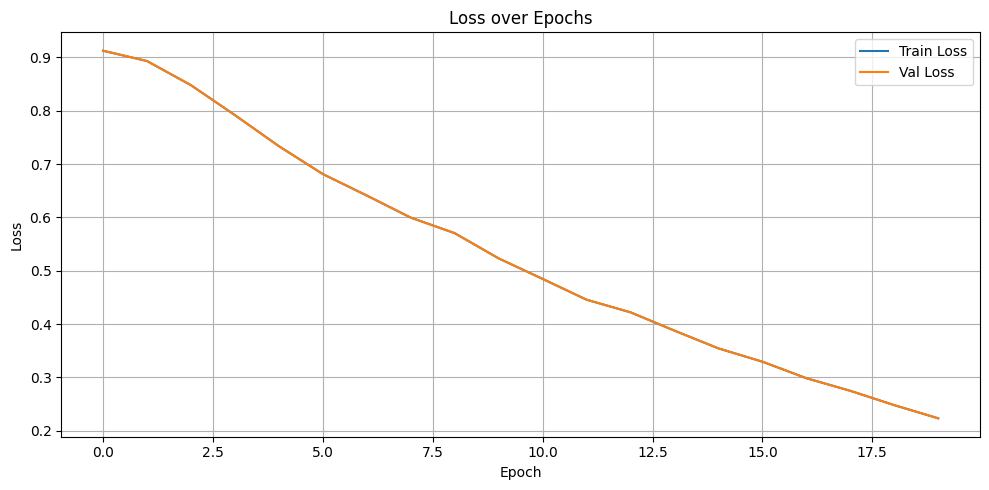

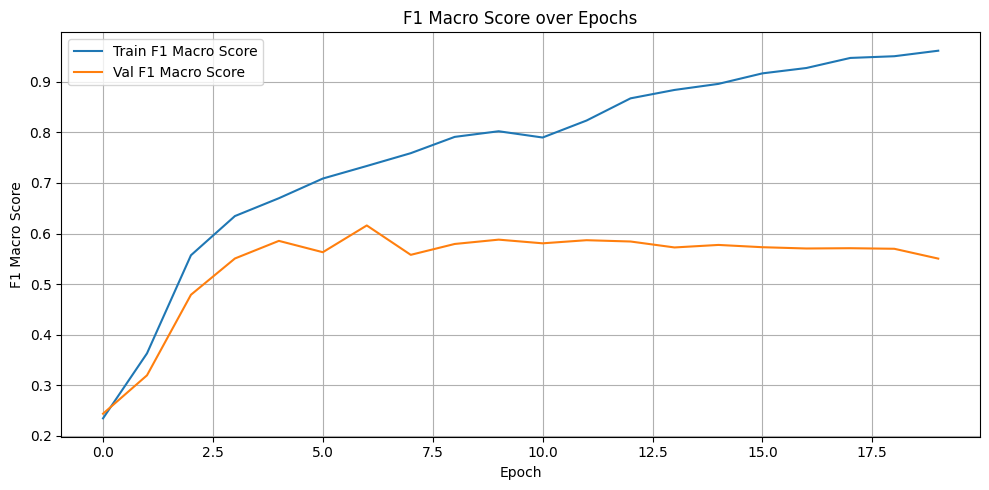

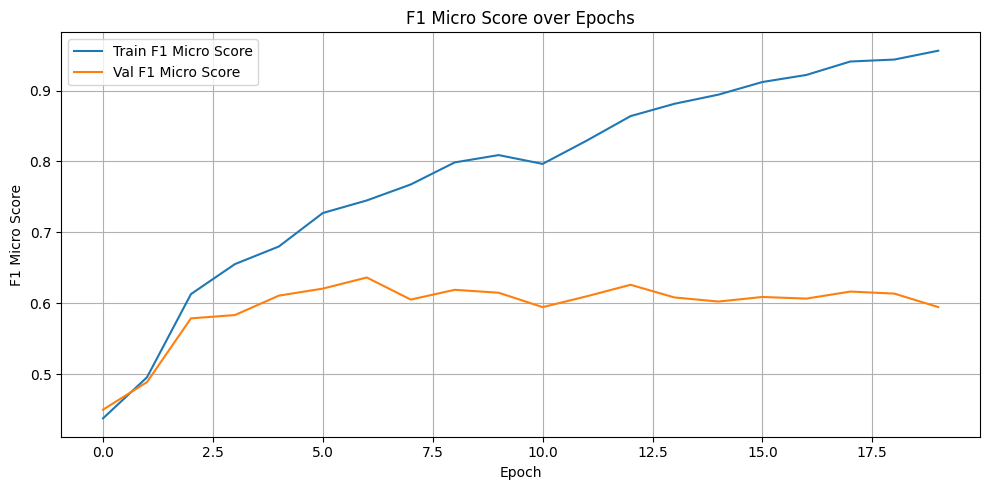

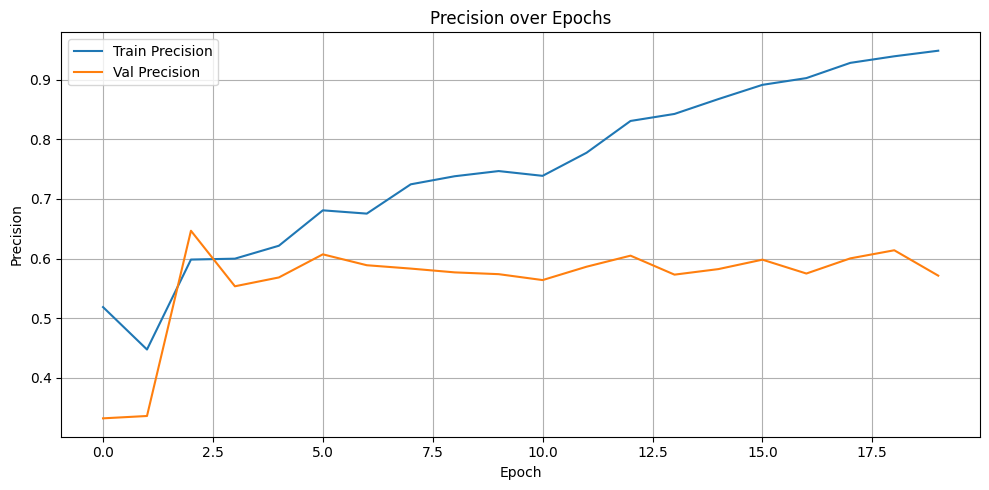

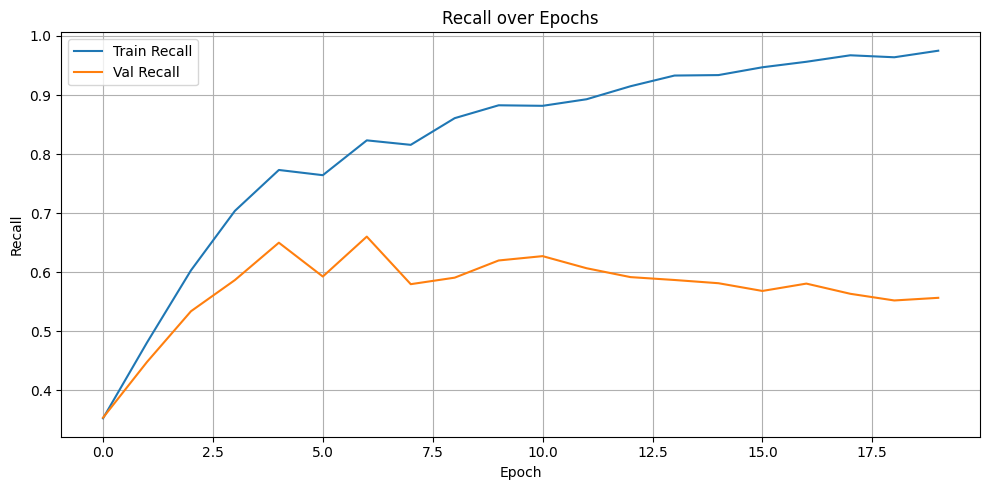

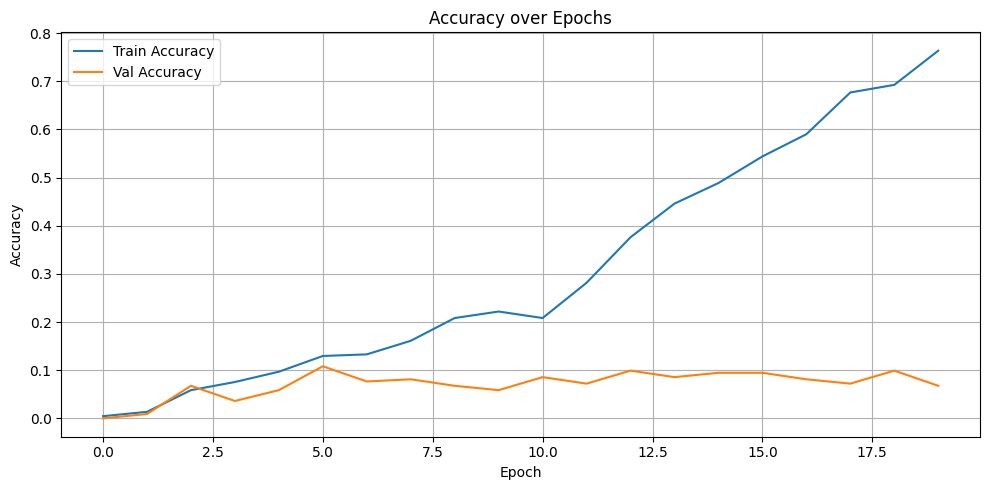

In [15]:
def plot_metrics(train, val, name):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f'Train {name}')
    plt.plot(val, label=f'Val {name}')
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.title(f"{name} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}_curve.png")
    plt.show()

plot_metrics(train_losses, train_losses, "Loss")
plot_metrics(train_f1macros, val_f1macros, "F1 Macro Score")
plot_metrics(train_f1micros, val_f1micros, "F1 Micro Score")
plot_metrics(train_precisions, val_precisions, "Precision")
plot_metrics(train_recalls, val_recalls, "Recall")
plot_metrics(train_accs, val_accs, "Accuracy")

In [34]:
def predict_emotions(text, model, tokenizer, threshold=0.5):
    model.eval()
    encoding = tokenizer(text,
                         max_length=512,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    preds = (probs >= threshold).astype(int)
    results = {emotion: float(prob) for emotion, prob in zip(all_emotions, probs)}
    predicted_emotions = [emotion for emotion, pred in zip(all_emotions, preds) if pred == 1]
    return predicted_emotions, results

In [35]:
text_ro = "O vreme, a fost greu în ultima vreme, am fost mai bine decât în ultimele patru decembrie reci pe care mi le amintesc. Și îmi văd familia în fiecare lună. Am găsit o fată pe care o iubesc părinții mei. Vine să stea peste noapte și cred că aș putea avea totul. Și îi mulțumesc lui Dumnezeu în fiecare zi pentru fata pe care mi-a trimis-o. Dar știu lucrurile pe care mi le dă, le poate lua. Și te țin în brațe în fiecare noapte. Și acesta e un sentiment cu care vreau să mă obișnuiesc. Dar nu există bărbat mai înspăimântat ca bărbatul care riscă să te piardă."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "For a while, it's been hard lately, I've been better than I've been in the last four cold Decembers that I can remember. And I see my family every month. I found a girl that my parents love. She's coming to stay overnight and I think I could have it all. And I thank God every day for the girl he sent me. But I know the things he gives me, he can take away. And I hold you in my arms every night. And that's a feeling I want to get used to. But there's no man more scared than the man who risks losing you."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.25462180376052856, 'Calmness': 0.21700303256511688, 'Joyful activation': 0.07339730858802795, 'Nostalgia': 0.7457106709480286, 'Power': 0.06979263573884964, 'Sadness': 0.857380747795105, 'Solemnity': 0.399049311876297, 'Tenderness': 0.82431560754776, 'Tension': 0.2518436014652252}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.33669307827949524, 'Calmness': 0.36703407764434814, 'Joyful activation': 0.037800345569849014, 'Nostalgia': 0.7912182211875916, 'Power': 0.04953649640083313, 'Sadness': 0.8130744695663452, 'Solemnity': 0.4115210175514221, 'Tenderness': 0.9528529644012451, 'Tension': 0.19420161843299866}


In [36]:
text_ro = "Simt cum îmi bate inima cu putere, e atât de greu să mă calmez, Sunt prea răbdător? Prea cald, m-a făcut să transpir pe podea (Ooh, transpir pe podea) Pur și simplu nu mai pot suporta (Woah-woah, oh, woah; Ah) Și suntem atât de aproape, văd în ochii tăi Dacă există o șansă o să profit, te implor, te rog dă-mi un semn Aștept de prea mult timp, cred că e timpul, mm-hmm Toată magia asta arde ca un foc înăuntru Și e mult prea cald, fată, ar trebui să ne eliberăm Am așteptat să fiu lângă tine Îmi dau seama cât de mult îți dorești și tu, ooh Toată tensiunea asta, iubito, eliberează-ți corpul (Ha) Suntem doar tu și eu Ne privim in ochi in aceasta cameră aglomerată Felul în care te uiți la mine, nu pot refuza Toată tensiunea asta, iubito, eliberează-ți corpul, da, iubito Coadă de cal așezată exact cum trebuie desfa-o fată, nu Fii timida, mă bucur că am spart gheața. Hai să continuăm să dansăm (Dansăm, dansăm). Iubito, ți-o pot da cum vrei (Cum vrei)."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "I feel my heart pounding, it's so hard to calm down, Am I too patient? Too hot, got me sweating on the floor (Ooh, sweating on the floor) I just can't take it anymore (Woah-woah, oh, woah; Ah) And we're so close, I see it in your eyes If there's a chance I can take it, I'm begging you, please give me a sign I've been waiting too long, I think it's time, mm-hmm All this magic burns like a fire inside And it's way too hot, girl, we should let it loose I've been waiting to be get next to you I realize how much you want it too, ooh All this tension, baby, let your body loose (Ha) It's just you and me Locking eyes inside this crowded room The way you look at me, I can't refuse All this tension, baby, let your body loose, yeah, baby let it loose, ponytail sitting just right, Let it down, girl, don't be shy, I'm just glad we broke the ice. Let's on keep dancing (Dancing, dancing). Baby, I can give it to you any way you want (Any way you want)."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Joyful activation', 'Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.46036937832832336, 'Calmness': 0.24207331240177155, 'Joyful activation': 0.5250474214553833, 'Nostalgia': 0.5518420934677124, 'Power': 0.10091247409582138, 'Sadness': 0.5277100205421448, 'Solemnity': 0.10491669178009033, 'Tenderness': 0.9681011438369751, 'Tension': 0.2100820690393448}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness', 'Tension']
Probabilities per emotion: {'Amazement': 0.24901948869228363, 'Calmness': 0.22579212486743927, 'Joyful activation': 0.37031206488609314, 'Nostalgia': 0.5831659436225891, 'Power': 0.21708010137081146, 'Sadness': 0.6799272298812866, 'Solemnity': 0.09874716401100159, 'Tenderness': 0.9399247765541077, 'Tension': 0.5067104697227478}


In [37]:
text_ro = "Oamenii cred că sunt mare, dar sunt mic. Nu sunt mulțumit de obiective. Mă uit la visele mele, și tot cresc. Îmi dau un nume scării, do-re-mi-fa. Puterea Regelui Uriaș e o armă, urechile mele sunt deschise. O văd în ochii mei, e toxică, capacitatea mea e atât de mare. Sunt ca o furnică lucrătoare. Dar voi depăși durerea și voi deveni un gigant. Ne numesc Dumnezeul Zeilor. Să ne folosim puterile pe care le deținem pentru propriile lor dorințe, să le privim cum explodează. Sunt cunoscut ca un gigant. Nu, nu, nu, sunt, dar neg. Avem locuri de mers, avem locuri în care să curg. Nu sunt mulțumit, îmi doresc mai mult. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, zdrobind lumi sub pământ. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, trecând peste deficiențe. Aleargă, aleargă, aleargă înainte să venim, vino, vino. Ard, arde, arde, pentru că nu am terminat, gata, gata. Aleargă, aleargă, aleargă înainte să venim, vino, vino, sunt un gigant, zdrobind lumile de dedesubt"
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "People think I'm big, but I'm small. I'm not satisfied with goals. I look at my dreams, and I'm still growing. I give my ladder a name, do-re-mi-fa. The power of the Giant King is a weapon, my ears are open. I see it in my eyes, it's toxic, my capacity is so great. I'm like a worker ant. But I will overcome the pain and become a giant. I call ourselves the God of Gods. Let's use the powers we hold for our own desires, let's watch them explode. I'm known as a giant. No, no, no, I am, but I deny it. We have places to walk, we have places to flow. I'm not satisfied, I want more. I'm a giant (Call me, call me, call me, call me, call me). I'm a giant, crushing worlds underground. I'm a giant (Call me, call me, call me, Call me, call me. I'm a giant, overcoming shortcomings. Run, run, run before we come, come, come. Burn, burn, burn, because I'm not done, done, done. Run, run, run before we come, come, come, I'm a giant, crushing the worlds below."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

Predicted emotions: ['Power', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.06280966848134995, 'Calmness': 0.4599667191505432, 'Joyful activation': 0.3483049273490906, 'Nostalgia': 0.2126266062259674, 'Power': 0.8778066039085388, 'Sadness': 0.444602370262146, 'Solemnity': 0.7510926127433777, 'Tenderness': 0.02352922037243843, 'Tension': 0.7137016654014587}
Predicted emotions: ['Power', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.07390996068716049, 'Calmness': 0.43692445755004883, 'Joyful activation': 0.3640885055065155, 'Nostalgia': 0.24359163641929626, 'Power': 0.9268116354942322, 'Sadness': 0.4039709270000458, 'Solemnity': 0.733163058757782, 'Tenderness': 0.021623054519295692, 'Tension': 0.7284522652626038}
